**Author:** Sydney Crandall

**Last Edited:** June 21st, 2022

This notebook includes an analysis of High Plains' seasonality from daily observations over a 10-year span from January 1st, 2012 through December 31st, 2021. Munging of the datasets was done using [munge.py] in another notebook. 

Features include:
- maximum and minimum temperature $(^{\circ}F)$
- hour of maximum and minimum temperature
- maximum and minimum Relative Humidity $(\%)$
- average dewpoint $(^{\circ}F$)
- averge wetbulb temperature $(^{\circ}F)$
- average wind direction $(^{\circ})$
- maximum wind speed $(mph)$
- total precipitation $(mm)$
- pressure tendency $(mbar)$

where pressure tendency is defined as the difference between the highest and lowest surface pressure recorded over the course of the day. Sign dependent on the hour at which the maximum and minimum surface pressure occur.
$$ p_{tend}=   \left\{
\begin{array}{ll}
      p_{max}-p_{min} & t_{max}>t_{min} \\
      p_{min}-p_{max} & t_{max}<t_{min} \\
\end{array} 
\right.  $$


Analysis includes:
- k-means clustering each location for 3 clusters, which was determined by the gap statistic, among other methods (see n_clust method in R)
- plotting the centroids, along with 1 standard deviation on either side and the respective size of the clusters, for each feature
- day-of-year vs. cluster for El Paso, Tx, Albuquerque, NM, Boulder, CO, and Glasgow, MT


In [188]:
# imports
import pandas as pd
import numpy as np
import cluster
import math
import munge
import datetime as dt
from metpy.units import units
import visualizations as vis
from scipy.stats import iqr
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import IFrame, display

In [189]:
filepath = "High_Plains_Observational_Network_Map.pdf"
IFrame(filepath, width=900, height=600)

### 1. Read in Munged datasets

In [239]:
# read in albequerque daily data
alb = pd.read_csv("albDaily.csv", index_col = 0)

# read in billings daily data
bil = pd.read_csv("billingsDaily.csv", index_col = 0)

# read in denver daily data
bou = pd.read_csv("bouDaily.csv", index_col = 0)

# read in glasgow daily data
gls = pd.read_csv("glsDaily.csv", index_col = 0)

# read in casper daily data
cas = pd.read_csv("casDaily.csv", index_col = 0)

# read in trinidad daily data
trd = pd.read_csv('trdDaily.csv', index_col = 0)

# read in el paso daily data
elp = pd.read_csv("elpDaily.csv", index_col = 0)

adjust_units = True

In [240]:
# change units to metric
# temp: F to C
# wspd: keep in mph (for now, maybe switch to kts)
# precip: in/day to mm/day
    
def unit_conversion(df):
    df['drytemp_max'] = ((df['drytemp_max']-32)*5/9).round(2)
    df['drytemp_min'] = ((df['drytemp_min']-32)*5/9).round(2)
    df['dewtemp_avg'] = ((df['dewtemp_avg']-32)*5/9).round(2)
    df['wetbulb_avg'] = ((df['wetbulb_avg']-32)*5/9).round(2)
    df['prec_mm_day'] = (df['prec_inch']*25.4).round(2)
    # drop prec_inch
    df.drop('prec_inch', axis = 1, inplace = True)
    return df

if adjust_units is True:
    elp = unit_conversion(elp)
    alb = unit_conversion(alb)
    trd = unit_conversion(trd)
    bou = unit_conversion(bou)
    cas = unit_conversion(cas)
    bil = unit_conversion(bil)
    gls = unit_conversion(gls)

### 2. Cluster datasets

In [241]:
# universal variables
included_cols = ['drytemp_max', 'drytemp_min','dewtemp_avg','wetbulb_avg', 'RH_max', 'RH_min','wspd_max','wdir_avg',
                 'prec_mm_day', 'drytemp_max_hour', 'drytemp_min_hour', 'pres_tend']
k = 3

In [242]:
# cluster alb
albData, albScaledData = cluster.scale_and_convert_to_numpy(alb, included_cols)
albScaledCentroids, albIdx = cluster.cluster_data(k, albScaledData)

# get alb centroids
albCentroids = cluster.get_centroids(albScaledCentroids, included_cols, albData)


# cluster bil
bilData, bilScaledData = cluster.scale_and_convert_to_numpy(bil, included_cols)
bilScaledCentroids, bilIdx = cluster.cluster_data(k, bilScaledData)

# get bil centroids
bilCentroids = cluster.get_centroids(bilScaledCentroids, included_cols, bilData)


# cluster bou
bouData, bouScaledData = cluster.scale_and_convert_to_numpy(bou, included_cols)
bouScaledCentroids, bouIdx = cluster.cluster_data(k, bouScaledData)

# get bou centroids
bouCentroids = cluster.get_centroids(bouScaledCentroids, included_cols, bouData)


# cluster gls
glsData, glsScaledData = cluster.scale_and_convert_to_numpy(gls,included_cols)
glsScaledCentroids, glsIdx = cluster.cluster_data(k, glsScaledData)

# get gls centroids
glsCentroids = cluster.get_centroids(glsScaledCentroids, included_cols, glsData)


# cluster cas
casData, casScaledData = cluster.scale_and_convert_to_numpy(cas,included_cols)
casScaledCentroids, casIdx = cluster.cluster_data(k, casScaledData)

# get cas centroids
casCentroids = cluster.get_centroids(casScaledCentroids, included_cols, casData)


# cluster trd
trdData, trdScaledData = cluster.scale_and_convert_to_numpy(trd,included_cols)
trdScaledCentroids, trdIdx = cluster.cluster_data(k, trdScaledData)

# get trd centroids
trdCentroids = cluster.get_centroids(trdScaledCentroids, included_cols, trdData)


# cluster elp
elpData, elpScaledData = cluster.scale_and_convert_to_numpy(elp,included_cols)
elpScaledCentroids, elpIdx = cluster.cluster_data(k, elpScaledData)

# get elp centroids
elpCentroids = cluster.get_centroids(elpScaledCentroids, included_cols, elpData)

### 3. Manipulate clustered datasets

In [243]:
# add latitude and locations to each centroid dataframe, then contatinate (from south to north)

latitudeList = [31.80345,35.08423,37.25792,39.73715,42.90601,45.783157,48.21300]
locationList = ['elp','alb','trd','bou','cas','bil','gls']

dfList = [elp, alb, trd, bou, cas, bil, gls]
indexList = [elpIdx, albIdx, trdIdx, bouIdx, casIdx, bilIdx, glsIdx]

for i in range(0,len(indexList)):
    dfList[i]['cluster'] = indexList[i]
    dfList[i]['location'] = locationList[i]
    dfList[i]['latitude'] = latitudeList[i]

In [195]:
# construct a dataframe of the feature means for each location
means = pd.DataFrame()

# add latitude (south to north)
means['latitude'] = [elp['latitude'].max(), alb["latitude"].max(), trd['latitude'].max(),bou['latitude'].max(),
                    cas['latitude'].max(), bil['latitude'].max(), gls['latitude'].max()]

# add the mean of each feature (included_cols) for each location to the dataframe
for feature in range(0,len(included_cols)):
    means[included_cols[feature]] = [elp[included_cols[feature]].mean(), alb[included_cols[feature]].mean(),
                                      trd[included_cols[feature]].mean(), bou[included_cols[feature]].mean(),
                                      cas[included_cols[feature]].mean(),bil[included_cols[feature]].mean(),
                                      gls[included_cols[feature]].mean()]

In [196]:
# add informed_cluster to dataframes based on cluster temperature (drytemp_max) and precipitation (prec_inch)

centroidsList = [elpCentroids, albCentroids, trdCentroids, bouCentroids, casCentroids, bilCentroids, glsCentroids]
drytempMeansList = means['drytemp_max'].tolist()

for i in range(0,len(centroidsList)):
    centroidsList[i]['informed_cluster'] = ''
    # check temperature
    centroidsList[i]['informed_cluster'].loc[(centroidsList[i]['drytemp_max'] <= drytempMeansList[i])] = 'Low Temp'
    centroidsList[i]['informed_cluster'].loc[(centroidsList[i]['drytemp_max'] >= drytempMeansList[i])] = 'High Temp'
    # check precipitation
    centroidsList[i]['informed_cluster'].loc[(centroidsList[i]['prec_mm_day'].idxmax())] = centroidsList[i]['informed_cluster'].loc[centroidsList[i]['prec_mm_day'].idxmax()]+' + Wet'
    centroidsList[i]['informed_cluster'].loc[(centroidsList[i]['prec_mm_day'].idxmin())] = centroidsList[i]['informed_cluster'].loc[centroidsList[i]['prec_mm_day'].idxmin()]+' + Dry'

for i in range(0,7):
    centroidsList[i]['location'] = locationList[i]
    centroidsList[i]['latitude'] = latitudeList[i]

allCentroids = pd.concat([elpCentroids, albCentroids, trdCentroids, bouCentroids, casCentroids, bilCentroids,
                             glsCentroids], axis = 0).reset_index(drop = True)

C:\Users\Sydney\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [197]:
# add informed_cluster (from centroids) to dataframes
for i in range(0,len(centroidsList)):
    dfList[i]['informed_cluster'] = dfList[i]['cluster'].map(centroidsList[i].set_index(centroidsList[i]['cluster'])['informed_cluster'])

# concatinate the dataframes, from south to north
alldf = pd.concat([elp, alb, trd, bou, cas, bil, gls], axis = 0, ignore_index = True)

In [198]:
# add columns for the % of days in each cluster with precipitation (prec_days_%) and the number of days (count)

prec_days = []
count = []

allGroups = alldf.groupby(['cluster','location'])

for i in range(0,len(locationList)):
    for k in range(1,4):
        prec_days.append(len(allGroups.get_group((k,locationList[i])).query('prec_mm_day > 0'))/len(allGroups.get_group((k,locationList[i])))*100)
        count.append(len(allGroups.get_group((k,locationList[i]))))

allCentroids['prec_days_%'] = prec_days
allCentroids['count'] = count

In [199]:
# change tilt_season from numeric to categorical
alldf['tilt_season'].loc[(alldf['tilt_season'] == 1)] = 'Winter'
alldf['tilt_season'].loc[(alldf['tilt_season'] == 2)] = 'Spring'
alldf['tilt_season'].loc[(alldf['tilt_season'] == 3)] = 'Summer'
alldf['tilt_season'].loc[(alldf['tilt_season'] == 4)] = 'Autumn'

In [200]:
# save the allCentroids and means dataframes as csv files for figure creation
allCentroids.to_csv('ObsAllCentroids.csv')
means.to_csv('ObsMeans.csv')

### 4. Figures

In [201]:
# color palette for plots

palette = {"High Temp + Wet":"firebrick",
           "High Temp + Dry": "tomato",
           "Low Temp + Dry":"cornflowerblue", 
           "Low Temp + Wet":"mediumblue",
           "Low Temp": 'cornflowerblue',
           "High Temp": 'tomato'}

groups = [('gls', 'Low Temp + Dry'), ('gls','Low Temp + Wet'),('gls','High Temp'),('bil','Low Temp + Dry'),('bil','Low Temp + Wet'),
         ('bil','High Temp'),('cas','Low Temp + Dry'),('cas','Low Temp + Wet'),('cas',"High Temp"),('bou','Low Temp + Dry'),
         ('bou','Low Temp + Wet'),('bou','High Temp'),('trd','Low Temp + Dry'),('trd','Low Temp + Wet'),('trd','High Temp'),
         ('alb', 'High Temp + Wet'),('alb',"High Temp + Dry"), ('alb','Low Temp'),('elp','High Temp + Wet'),('elp','High Temp + Dry'),
         ('elp','Low Temp')]

# offset for adding standard deviation lines to centroid scatterplots
offset = [-0.2,0,0.2]

alldfGroups = alldf.groupby(["location", 'informed_cluster'])

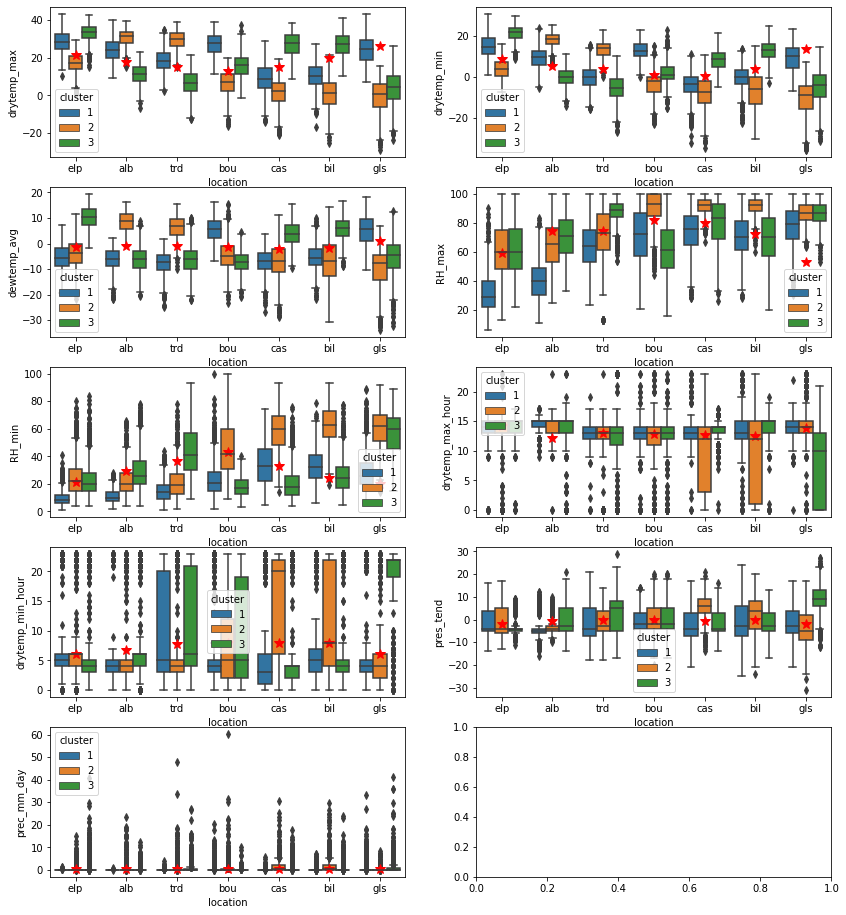

In [202]:
fig, axes = plt.subplots(5,2, figsize = (14,16))

sb.boxplot(y = "drytemp_max", x = "location", data = alldf, hue = "cluster",orient = "v",
          order = ['elp','alb','trd','bou','cas','bil','gls'], ax = axes[0,0])
axes[0,0].plot("alb",alb["drytemp_max"].mean(), 'r*', markersize = 10)
axes[0,0].plot("bou",bou["drytemp_max"].mean(),'r*', markersize = 10)
axes[0,0].plot("bil",bil["drytemp_max"].mean(),'r*', markersize = 10)
axes[0,0].plot('gls', gls["drytemp_max"].mean(),'r*', markersize = 10)
axes[0,0].plot('cas', cas["drytemp_max"].mean(),'r*',markersize = 10)
axes[0,0].plot('trd', trd["drytemp_max"].mean(),'r*',markersize = 10)
axes[0,0].plot('elp', elp["drytemp_max"].mean(),'r*',markersize = 10)

sb.boxplot(y = "drytemp_min", x = "location", data = alldf, hue = "cluster",orient = "v",
          order = ['elp','alb','trd','bou','cas','bil','gls'], ax = axes[0,1])
axes[0,1].plot("alb",alb["drytemp_min"].mean(), 'r*', markersize = 10)
axes[0,1].plot("bou",bou["drytemp_min"].mean(),'r*', markersize = 10)
axes[0,1].plot("bil",bil["drytemp_min"].mean(),'r*', markersize = 10)
axes[0,1].plot('gls', gls["drytemp_min"].mean(),'r*', markersize = 10)
axes[0,1].plot('cas', cas["drytemp_min"].mean(),'r*',markersize = 10)
axes[0,1].plot('trd', trd["drytemp_min"].mean(),'r*',markersize = 10)
axes[0,1].plot('elp', elp["drytemp_min"].mean(),'r*',markersize = 10)

sb.boxplot(y = "dewtemp_avg", x = "location", data = alldf, hue = "cluster",orient = "v",
          order = ['elp','alb','trd','bou','cas','bil','gls'], ax = axes[1,0])
axes[1,0].plot("alb",alb["dewtemp_avg"].mean(), 'r*', markersize = 10)
axes[1,0].plot("bou",bou["dewtemp_avg"].mean(),'r*', markersize = 10)
axes[1,0].plot("bil",bil["dewtemp_avg"].mean(),'r*', markersize = 10)
axes[1,0].plot('gls', gls["dewtemp_avg"].mean(),'r*', markersize = 10)
axes[1,0].plot('cas', cas["dewtemp_avg"].mean(),'r*',markersize = 10)
axes[1,0].plot('trd', trd["dewtemp_avg"].mean(),'r*',markersize = 10)
axes[1,0].plot('elp', elp["dewtemp_avg"].mean(),'r*',markersize = 10)

sb.boxplot(y = "RH_max", x = "location", data = alldf, hue = "cluster",orient = "v",
          order = ['elp','alb','trd','bou','cas','bil','gls'], ax = axes[1,1])
axes[1,1].plot("alb",alb["RH_max"].mean(), 'r*', markersize = 10)
axes[1,1].plot("bou",bou["RH_max"].mean(),'r*', markersize = 10)
axes[1,1].plot("bil",bil["RH_max"].mean(),'r*', markersize = 10)
axes[1,1].plot('gls', gls["RH_max"].mean(),'r*', markersize = 10)
axes[1,1].plot('cas', cas["RH_max"].mean(),'r*',markersize = 10)
axes[1,1].plot('trd', trd["RH_max"].mean(),'r*',markersize = 10)
axes[1,1].plot('elp', elp["RH_max"].mean(),'r*',markersize = 10)

sb.boxplot(y = "RH_min", x = "location", data = alldf, hue = "cluster",orient = "v",
          order = ['elp','alb','trd','bou','cas','bil','gls'], ax = axes[2,0])
axes[2,0].plot("alb",alb["RH_min"].mean(), 'r*', markersize = 10)
axes[2,0].plot("bou",bou["RH_min"].mean(),'r*', markersize = 10)
axes[2,0].plot("bil",bil["RH_min"].mean(),'r*', markersize = 10)
axes[2,0].plot('gls', gls["RH_min"].mean(),'r*', markersize = 10)
axes[2,0].plot('cas', cas["RH_min"].mean(),'r*',markersize = 10)
axes[2,0].plot('trd', trd["RH_min"].mean(),'r*',markersize = 10)
axes[2,0].plot('elp', elp["RH_min"].mean(),'r*',markersize = 10)

sb.boxplot(y = "drytemp_max_hour", x = "location", data = alldf, hue = "cluster",orient = "v",
          order = ['elp','alb','trd','bou','cas','bil','gls'], ax = axes[2,1])
axes[2,1].plot("alb",alb["drytemp_max_hour"].mean(), 'r*', markersize = 10)
axes[2,1].plot("bou",bou["drytemp_max_hour"].mean(),'r*', markersize = 10)
axes[2,1].plot("bil",bil["drytemp_max_hour"].mean(),'r*', markersize = 10)
axes[2,1].plot('gls', gls["drytemp_max_hour"].mean(),'r*', markersize = 10)
axes[2,1].plot('cas', cas["drytemp_max_hour"].mean(),'r*',markersize = 10)
axes[2,1].plot('trd', trd["drytemp_max_hour"].mean(),'r*',markersize = 10)
axes[2,1].plot('elp', elp["drytemp_max_hour"].mean(),'r*',markersize = 10)

sb.boxplot(y = "drytemp_min_hour", x = "location", data = alldf, hue = "cluster",orient = "v",
          order = ['elp','alb','trd','bou','cas','bil','gls'], ax = axes[3,0])
axes[3,0].plot("alb",alb["drytemp_min_hour"].mean(), 'r*', markersize = 10)
axes[3,0].plot("bou",bou["drytemp_min_hour"].mean(),'r*', markersize = 10)
axes[3,0].plot("bil",bil["drytemp_min_hour"].mean(),'r*', markersize = 10)
axes[3,0].plot('gls', gls["drytemp_min_hour"].mean(),'r*', markersize = 10)
axes[3,0].plot('cas', cas["drytemp_min_hour"].mean(),'r*',markersize = 10)
axes[3,0].plot('trd', trd["drytemp_min_hour"].mean(),'r*',markersize = 10)
axes[3,0].plot('elp', elp["drytemp_min_hour"].mean(),'r*',markersize = 10)

sb.boxplot(y = "pres_tend", x = "location", data = alldf, hue = "cluster",orient = "v",
          order = ['elp','alb','trd','bou','cas','bil','gls'], ax = axes[3,1])
axes[3,1].plot("alb",alb["pres_tend"].mean(), 'r*', markersize = 10)
axes[3,1].plot("bou",bou["pres_tend"].mean(),'r*', markersize = 10)
axes[3,1].plot("bil",bil["pres_tend"].mean(),'r*', markersize = 10)
axes[3,1].plot('gls', gls["pres_tend"].mean(),'r*', markersize = 10)
axes[3,1].plot('cas', cas["pres_tend"].mean(),'r*',markersize = 10)
axes[3,1].plot('trd', trd["pres_tend"].mean(),'r*',markersize = 10)
axes[3,1].plot('elp', elp["pres_tend"].mean(),'r*',markersize = 10)

sb.boxplot(y = "prec_mm_day", x = "location", data = alldf, hue = "cluster",orient = "v",
          order = ['elp','alb','trd','bou','cas','bil','gls'], ax = axes[4,0])
axes[4,0].plot("alb",alb["prec_mm_day"].mean(), 'r*', markersize = 10)
axes[4,0].plot("bou",bou["prec_mm_day"].mean(),'r*', markersize = 10)
axes[4,0].plot("bil",bil["prec_mm_day"].mean(),'r*', markersize = 10)
axes[4,0].plot('gls', gls["prec_mm_day"].mean(),'r*', markersize = 10)
axes[4,0].plot('cas', cas["prec_mm_day"].mean(),'r*',markersize = 10)
axes[4,0].plot('trd', trd["prec_mm_day"].mean(),'r*',markersize = 10)
axes[4,0].plot('elp', elp["prec_mm_day"].mean(),'r*',markersize = 10)

**For the figure below:**
- Change up the order of the figures to one that actually makes sense
- Decide which metrics are useful to keep
- potentially change the informed_cluster column to a categorical variable for the legend **(done)**
- add a title
- maybe change the font of the whole plot to times new roman?
- make one universal legend for all the plots, placed at the top or bottom center of the image **(done)**
- change the palette to one with more differentiation between categories

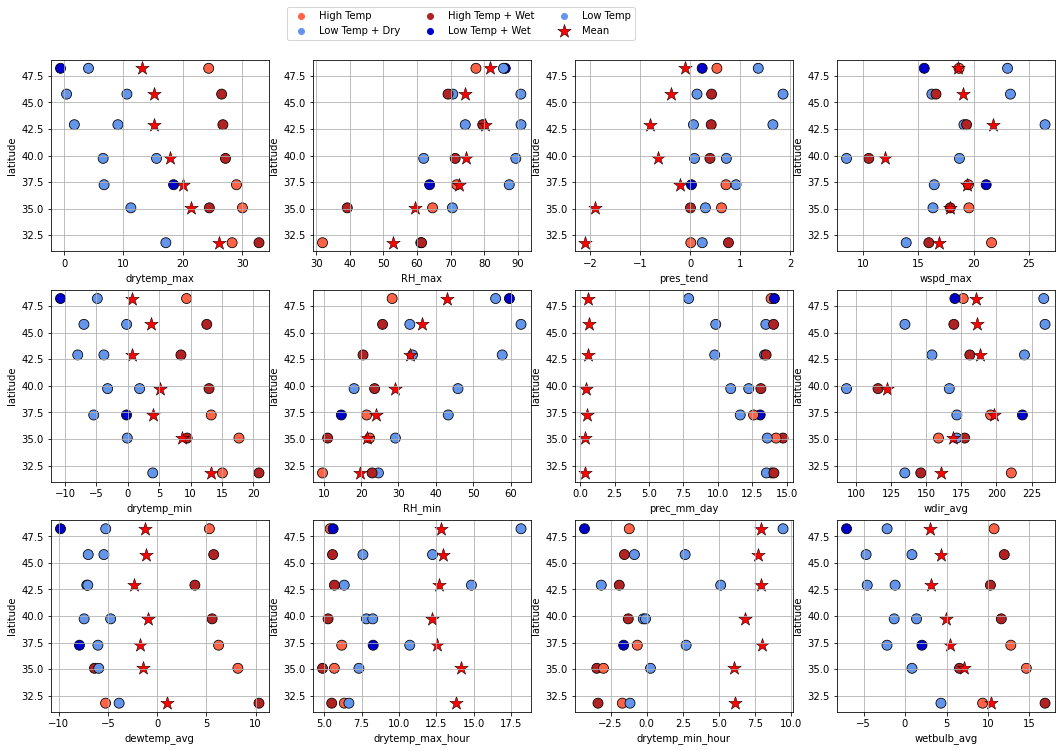

In [203]:
fig, axes = plt.subplots(3,4, figsize = (18,12))
axes[0,0].grid()
sb.scatterplot(x ='drytemp_max', y='latitude', data = allCentroids,
              s = 100, ax =axes[0,0], hue = 'informed_cluster', palette = palette, legend = False, edgecolor = 'black')
sb.scatterplot(x = 'drytemp_max', y = 'latitude', data = means, s = 200, ax = axes[0,0], color = 'red', marker = "*",
              edgecolor = 'black', linewidth = 0.5)

sb.scatterplot(x = 'drytemp_min', y = 'latitude', data = allCentroids,
              s = 100, hue = "informed_cluster", ax = axes[1,0], palette = palette, legend = False, edgecolor = 'black')
sb.scatterplot(x = 'drytemp_min', y = 'latitude', data = means, s = 200, ax = axes[1,0], color = 'red', marker = "*",
              edgecolor = 'black', linewidth = 0.5)
axes[1,0].grid()

sb.scatterplot(x = 'RH_max', y = 'latitude', data = allCentroids,
              s = 100, hue = "informed_cluster", ax = axes[0,1], palette = palette, edgecolor = 'black')
sb.scatterplot(x = 'RH_max', y = 'latitude', data = means, s = 200, ax = axes[0,1], color = 'red', marker = "*",
               label = 'Mean', edgecolor = 'black', linewidth = 0.5)
axes[0,1].grid()

sb.scatterplot(x = 'RH_min', y = 'latitude', data = allCentroids,
              s = 100, hue = "informed_cluster", ax = axes[1,1], palette = palette, legend = False, edgecolor = 'black')
sb.scatterplot(x = 'RH_min', y = 'latitude', data = means, s = 200, ax = axes[1,1], color = 'red', marker = "*",
              edgecolor = 'black', linewidth = 0.5)
axes[1,1].grid()

sb.scatterplot(x = 'dewtemp_avg', y = 'latitude', data = allCentroids,
              s = 100, hue = "informed_cluster", ax = axes[2,0], palette = palette, legend = False, edgecolor = 'black')
sb.scatterplot(x = 'dewtemp_avg', y = 'latitude', data = means, s = 200, ax = axes[2,0], color = 'red', marker = "*",
              edgecolor = 'black', linewidth = 0.5)
axes[2,0].grid()

sb.scatterplot(x = 'drytemp_max_hour', y = 'latitude', data = allCentroids,
              s = 100, hue = "informed_cluster", ax = axes[2,1], palette = palette, legend = False, edgecolor = 'black')
sb.scatterplot(x = 'drytemp_max_hour', y = 'latitude', data = means, s = 200, ax = axes[2,1], color = 'red',
               marker = "*", edgecolor = 'black', linewidth = 0.5)
axes[2,1].grid()

sb.scatterplot(x = 'drytemp_min_hour', y = "latitude", data = allCentroids,
               s = 100, hue = "informed_cluster", ax = axes[2,2], palette = palette, legend = False, edgecolor = 'black')
sb.scatterplot(x = 'drytemp_min_hour', y = 'latitude', data = means, s = 200, ax = axes[2,2], color = 'red',
               marker = "*", edgecolor = 'black', linewidth = 0.5)
axes[2,2].grid()

sb.scatterplot(x='prec_mm_day', y='latitude', data = allCentroids,
               s=100, hue = 'informed_cluster', ax = axes[1,2], palette = palette, legend = False, edgecolor = 'black')
sb.scatterplot(x = 'prec_mm_day', y = 'latitude', data = means, s = 200, ax = axes[1,2], color = 'red', marker = "*",
              edgecolor = 'black', linewidth = 0.5, legend = False)
axes[1,2].grid()

sb.scatterplot(x='pres_tend', y='latitude', data = allCentroids,
               s=100, hue = "informed_cluster", ax = axes[0,2], palette = palette, legend = False, edgecolor = 'black')
sb.scatterplot(x = 'pres_tend', y = 'latitude', data = means, s = 200, ax = axes[0,2], color = 'red', marker = "*",
               edgecolor = 'black', linewidth = 0.5, legend = False)
axes[0,2].grid()

sb.scatterplot(x = 'wspd_max', y = 'latitude', data = allCentroids, 
              s = 100, hue = 'informed_cluster', ax = axes[0,3], palette = palette, legend = False, edgecolor = 'black')
sb.scatterplot(x = 'wspd_max', y = 'latitude', data = means, s = 200, ax = axes[0,3], color = 'red', marker = '*',
              edgecolor = 'black', linewidth = 0.5, legend = False)
axes[0,3].grid()

sb.scatterplot(x = 'wdir_avg', y = 'latitude', data = allCentroids,
               s = 100, hue = 'informed_cluster', ax = axes[1,3], palette = palette, legend = False, edgecolor = 'black')
sb.scatterplot(x = 'wdir_avg', y = 'latitude', data = means, s = 200, ax = axes[1,3], color = 'red', marker = '*',
               edgecolor = 'black', linewidth = 0.5, legend = False)
axes[1,3].grid()

sb.scatterplot(x = 'wetbulb_avg', y = 'latitude', data = allCentroids,
               s = 100, hue = 'informed_cluster', ax = axes[2,3], palette = palette, legend = False, edgecolor = 'black')
sb.scatterplot(x = 'wetbulb_avg', y = 'latitude', data = means, s = 200, ax = axes[2,3], color = 'red', marker = '*',
               edgecolor = 'black', linewidth = 0.5, legend = False)
axes[2,3].grid()

axes[0,1].legend(ncol = 3, bbox_to_anchor = (1.5,1.3))
fig.savefig("DailyCentroidsPlot.jpg")

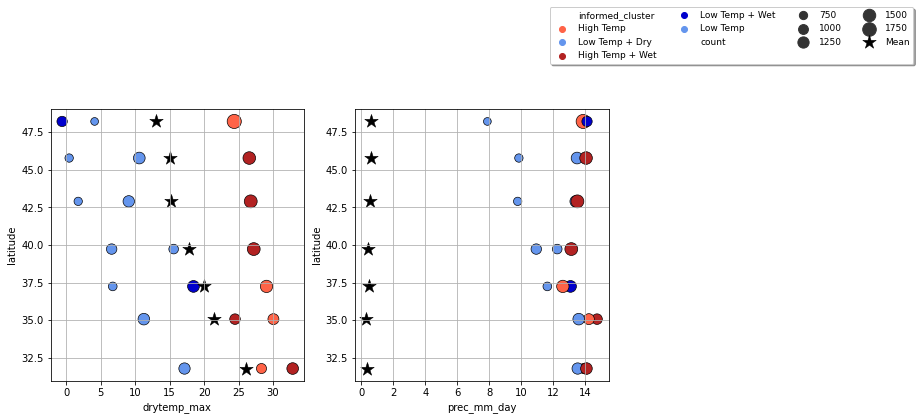

In [204]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].grid()
sb.scatterplot(x ='drytemp_max', y='latitude', data = allCentroids,
              sizes = (60,200), ax =axes[0], hue = 'informed_cluster', palette = palette, edgecolor = 'black',
               legend = False, size = 'count')
sb.scatterplot(x = 'drytemp_max', y = 'latitude', data = means, s = 200, ax = axes[0], color = 'black', marker = "*",
              edgecolor = 'black', linewidth = 0.5)

sb.scatterplot(x='prec_mm_day', y='latitude', data = allCentroids,
               sizes=(60,200), size = 'count', hue = 'informed_cluster', ax = axes[1], palette = palette, legend = True, edgecolor = 'black')
sb.scatterplot(x = 'prec_mm_day', y = 'latitude', data = means, s = 200, ax = axes[1], color = 'black', marker = "*",
              edgecolor = 'black', linewidth = 0.5, label = "Mean")
axes[1].grid()

axes[1].legend(fontsize = 9, shadow = True, bbox_to_anchor = (0.75,1.15), ncol = 4)

fig.savefig('tempMax_prec.png', bbox_inches = 'tight', dpi = 100)

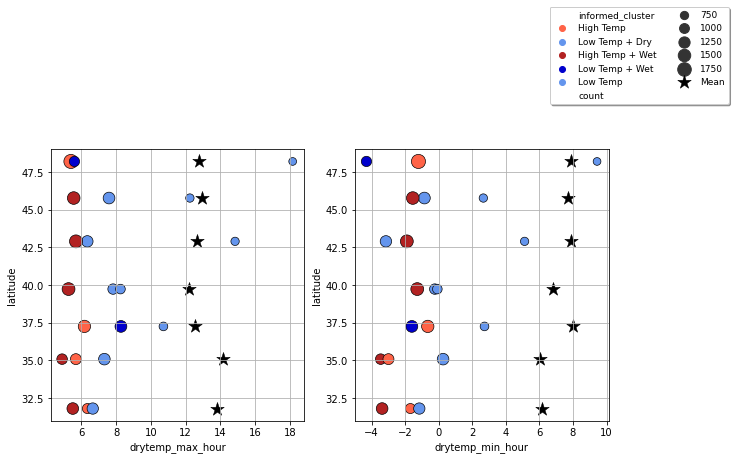

In [205]:
fig,axes = plt.subplots(1,2, figsize = (10,5))
axes[0].grid()
sb.scatterplot(x = 'drytemp_max_hour', y = 'latitude', data = allCentroids,
              sizes = (60,200), size = 'count', hue = "informed_cluster", ax = axes[0], palette = palette,
               legend = False, edgecolor = 'black')
sb.scatterplot(x = 'drytemp_max_hour', y = 'latitude', data = means, s = 200, ax = axes[0], color = 'black',
               marker = "*", edgecolor = 'black', linewidth = 0.5)

sb.scatterplot(x = 'drytemp_min_hour', y = "latitude", data = allCentroids,
               sizes = (60,200), size = 'count', hue = "informed_cluster", ax = axes[1], palette = palette,
               edgecolor = 'black')
sb.scatterplot(x = 'drytemp_min_hour', y = 'latitude', data = means, s = 200, ax = axes[1], color = 'black',
               marker = "*", edgecolor = 'black', linewidth = 0.5, label = "Mean")
axes[1].grid()

axes[1].legend(fontsize = 9, shadow = True, ncol = 2, bbox_to_anchor = (0.75,1.15))

fig.savefig("temp_hours.png", bbox_inches = 'tight', dpi = 100)

<AxesSubplot:xlabel='location', ylabel='drytemp_max'>

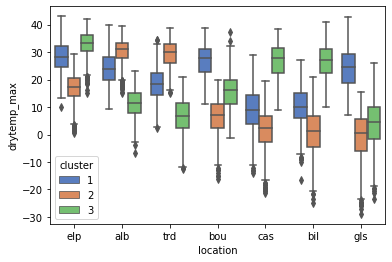

In [206]:
sb.boxplot(y = "drytemp_max", x = 'location', data = alldf, hue = 'cluster', palette = 'muted' )

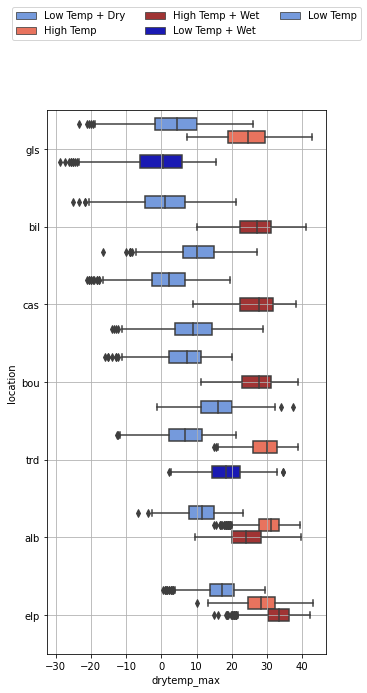

In [207]:
plt.figure(figsize = (5,10))
sb.boxplot(y = "location", x = 'drytemp_max', data = alldf, hue = 'informed_cluster',
          order = ['gls',"bil", 'cas',"bou",'trd', "alb", 'elp'], palette = palette)
plt.legend(loc = 9, ncol = 3, bbox_to_anchor = (0.5,1.2))
plt.grid()

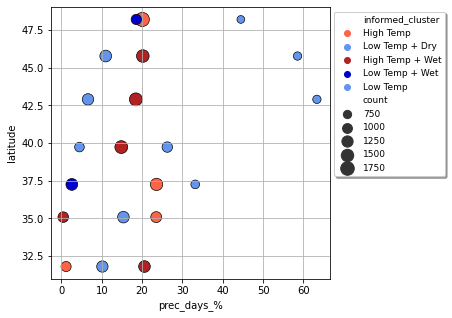

In [208]:
fig = plt.figure(figsize = (5,5))
sb.scatterplot(x = 'prec_days_%', y = 'latitude', data = allCentroids, hue = 'informed_cluster', palette = palette,
               sizes =(60,200), size = 'count', edgecolor = 'black')
plt.grid()
plt.legend(shadow = True, fontsize = 9, bbox_to_anchor = (1,1))

fig.savefig('prec_days%.png', dpi = 300)

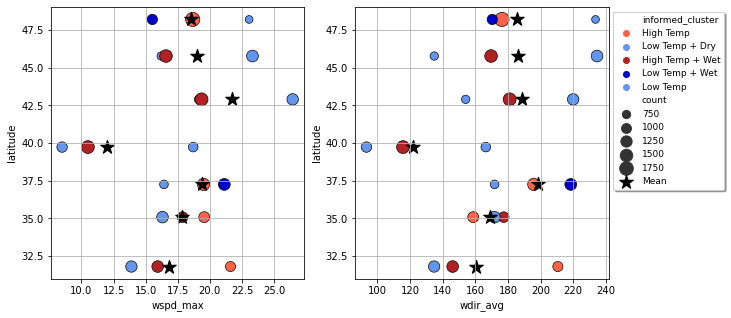

In [209]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
sb.scatterplot(x = 'wspd_max', y = 'latitude', data = allCentroids, hue = 'informed_cluster', palette = palette, sizes = (60,200),
               edgecolor = 'black', ax = axes[0], legend = False, size = 'count')
sb.scatterplot(x = 'wspd_max', y = 'latitude', data = means, marker = "*", color = "black", edgecolor = "black", s = 200,
               ax = axes[0])
axes[0].grid()

sb.scatterplot(x= 'wdir_avg', y = 'latitude', data = allCentroids, hue = "informed_cluster", palette = palette, sizes = (60,200),
               edgecolor = 'black', ax = axes[1], size = 'count')
sb.scatterplot(x = 'wdir_avg', y = 'latitude', data = means, color = 'black', marker = '*', s = 200, edgecolor = 'black',
               ax = axes[1], label = 'Mean')
axes[1].grid()

axes[1].legend(fontsize = 9, shadow = True, bbox_to_anchor = (1,1))

fig.savefig('winds.png', bbox_inches = 'tight', dpi = 300)

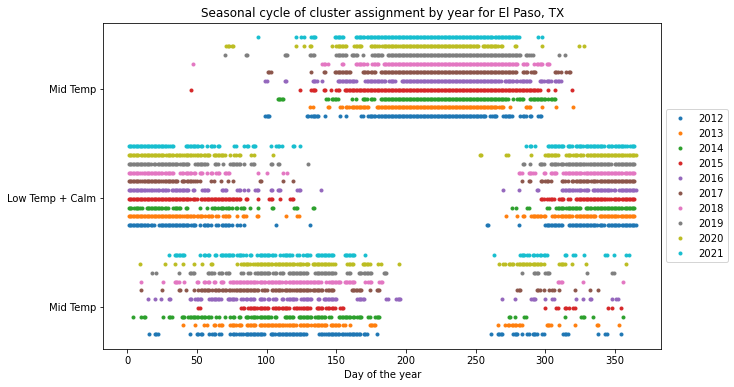

In [210]:
## What portion of the year, on average, is represented by each cluster?
## This can be the seasonal_assignment_by_year plot from ATOC4500
# city, cluster_label_list, NO_CLUSTERS, selectdf, idx
cluster_label_list = ["Mid Temp", "Low Temp + Calm", "Mid Temp"]
elp['datetime'] = pd.to_datetime(elp['datetime'], format = "%Y-%m-%d")
vis.seasonal_assignment_by_year("El Paso, TX", cluster_label_list, 3, elp, elpIdx)

plt.savefig('elp_seasonal.png', bbox_inches = 'tight', dpi = 300)

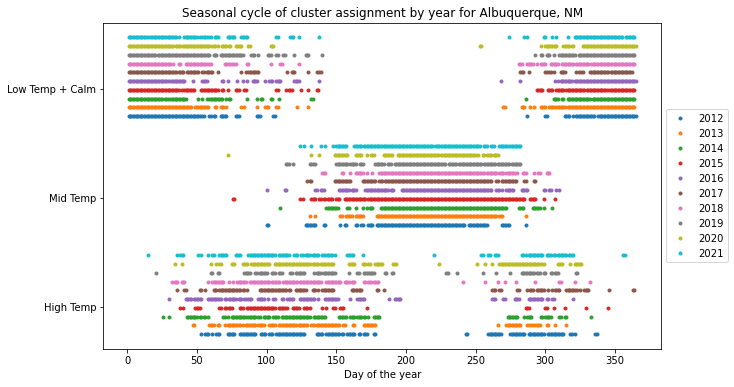

In [211]:
cluster_label_list = ['High Temp', "Mid Temp", "Low Temp + Calm"]
alb["datetime"] = pd.to_datetime(elp["datetime"], format = "%Y-%m-%d")
vis.seasonal_assignment_by_year("Albuquerque, NM", cluster_label_list, 3, alb, albIdx)


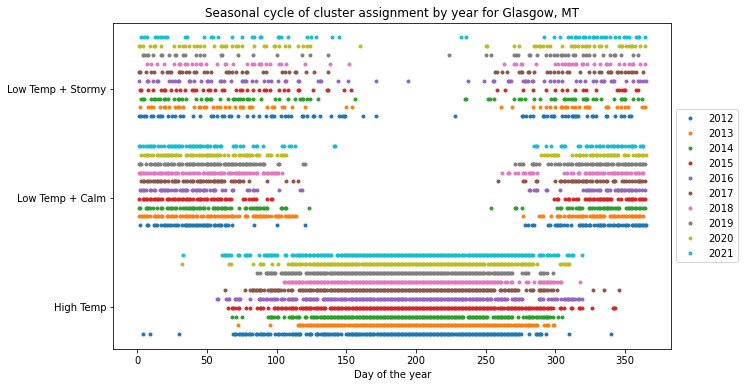

In [212]:
cluster_label_list = ['High Temp', 'Low Temp + Calm', 'Low Temp + Stormy']
gls['datetime'] = pd.to_datetime(gls['datetime'], format = '%Y-%m-%d')
vis.seasonal_assignment_by_year("Glasgow, MT", cluster_label_list, 3, gls, glsIdx)

plt.savefig('gls_seasonal.png', bbox_inches = 'tight', dpi = 300)

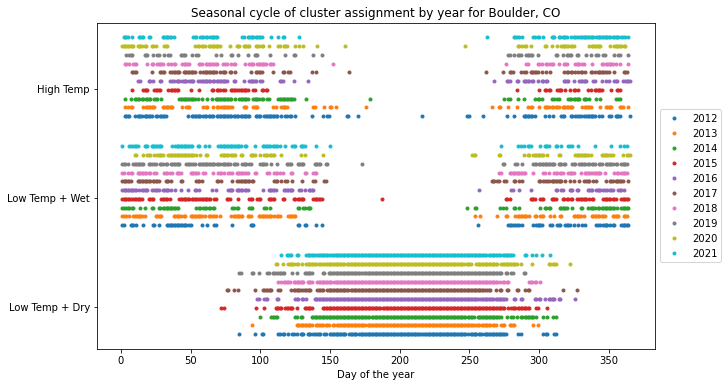

In [213]:
cluster_label_list = ['Low Temp + Dry', 'Low Temp + Wet', 'High Temp']
bou['datetime'] = pd.to_datetime(bou['datetime'], format = "%Y-%m-%d")
vis.seasonal_assignment_by_year("Boulder, CO", cluster_label_list, 3, bou, bouIdx)

plt.savefig('bou_seasonal.png', bbox_inches = 'tight',dpi = 300)

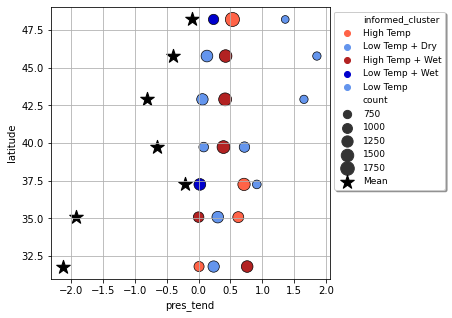

In [214]:
fig = plt.figure(figsize = (5,5))
sb.scatterplot(x = 'pres_tend', y = 'latitude', data = allCentroids, hue = 'informed_cluster', palette = palette,
               sizes = (60,200), size = 'count', edgecolor = 'black')
sb.scatterplot(x = 'pres_tend', y = "latitude", data = means, color = 'black', marker = "*", edgecolor = 'black', s = 200,
               label = 'Mean')
plt.grid()
plt.legend(shadow = True, fontsize = 9, bbox_to_anchor = (1,1))

fig.savefig('pres_tend.png', dpi = 300, bbox_inches = 'tight')

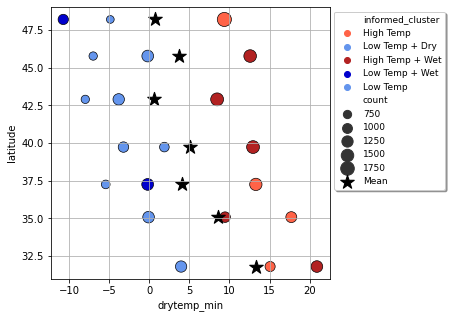

In [215]:
fig = plt.figure(figsize = (5,5))
sb.scatterplot(x = 'drytemp_min', y = 'latitude', data = allCentroids, hue = 'informed_cluster', palette = palette,
               sizes = (60,200), edgecolor = 'black', size = 'count')
sb.scatterplot(x = 'drytemp_min', y = "latitude", data = means, color = 'black', marker = "*", edgecolor = 'black', s = 200,
               label = 'Mean')
plt.grid()
plt.legend(shadow = True, fontsize = 9, bbox_to_anchor = (1,1))

fig.savefig('drytemp_min.png', dpi = 300, bbox_inches = 'tight')

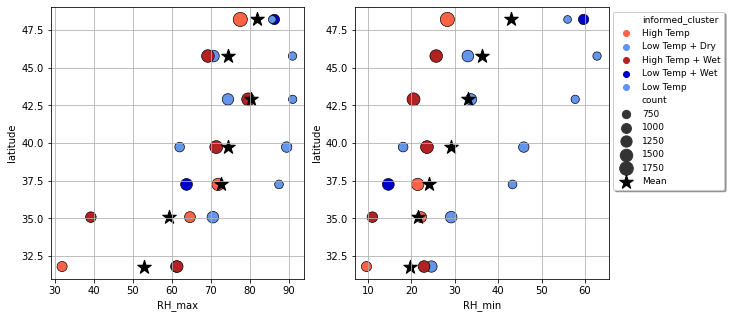

In [216]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
sb.scatterplot(x = 'RH_max', y = 'latitude', data = allCentroids, hue = 'informed_cluster', palette = palette, sizes = (60,200),
               edgecolor = 'black', ax = axes[0], legend = False, size = 'count')
sb.scatterplot(x = 'RH_max', y = 'latitude', data = means, marker = "*", color = "black", edgecolor = "black", s = 200,
               ax = axes[0])
axes[0].grid()

sb.scatterplot(x= 'RH_min', y = 'latitude', data = allCentroids, hue = "informed_cluster", palette = palette, sizes = (60,200),
               edgecolor = 'black', ax = axes[1], size = 'count')
sb.scatterplot(x = 'RH_min', y = 'latitude', data = means, color = 'black', marker = '*', s = 200, edgecolor = 'black',
               ax = axes[1], label = 'Mean')
axes[1].grid()

axes[1].legend(fontsize = 9, shadow = True, bbox_to_anchor = (1,1))

fig.savefig('RH.png', bbox_inches = 'tight', dpi = 300)

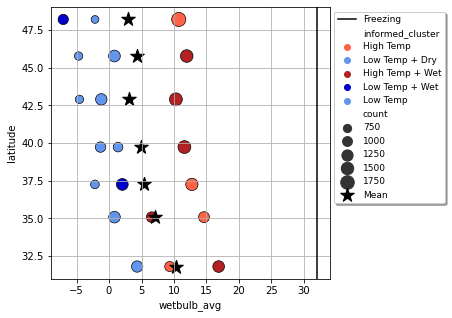

In [217]:
fig = plt.figure(figsize = (5,5))
sb.scatterplot(x = 'wetbulb_avg', y = 'latitude', data = allCentroids, hue = 'informed_cluster', palette = palette,
               sizes = (60,200), edgecolor = 'black', size = 'count')
sb.scatterplot(x = 'wetbulb_avg', y = "latitude", data = means, color = 'black', marker = "*", edgecolor = 'black', s = 200,
               label = 'Mean')
plt.axvline(32, color = 'black', label = 'Freezing')
plt.grid()
plt.legend(shadow = True, fontsize = 9, bbox_to_anchor = (1,1))

fig.savefig('wetbulb_avg.png', dpi = 300, bbox_inches = 'tight')

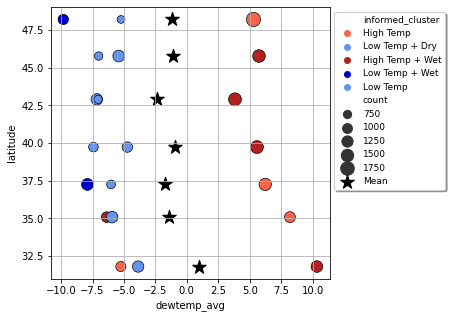

In [218]:
fig = plt.figure(figsize = (5,5))
sb.scatterplot(x = 'dewtemp_avg', y = 'latitude', data = allCentroids, hue = 'informed_cluster', palette = palette,
               sizes = (60,200), edgecolor = 'black', size = 'count')
sb.scatterplot(x = 'dewtemp_avg', y = "latitude", data = means, color = 'black', marker = "*", edgecolor = 'black', s = 200,
               label = 'Mean')
plt.grid()
plt.legend(shadow = True, fontsize = 9, bbox_to_anchor = (1,1))

fig.savefig('dewtemp_avg.png', dpi = 300, bbox_inches = 'tight')

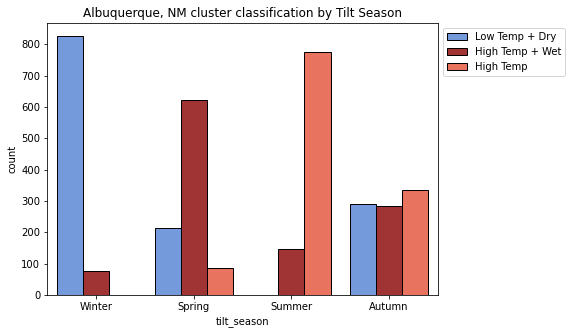

In [219]:
fig = plt.figure(figsize = (7,5))
sb.countplot(x = 'tilt_season', data = alldf.query('location == "alb"'), hue = 'informed_cluster', edgecolor = 'black',
             palette = palette)
plt.title("Albuquerque, NM cluster classification by Tilt Season")
plt.legend(bbox_to_anchor = (1,1))

fig.savefig("alb_class.png", bbox_inches = 'tight', dpi = 300)

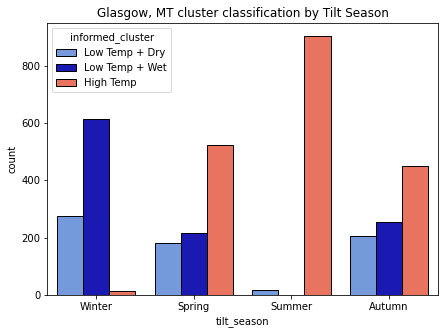

In [220]:
fig = plt.figure(figsize = (7,5))
sb.countplot(x = 'tilt_season', data = alldf.query('location == "gls"'), hue = 'informed_cluster', edgecolor = 'black',
             palette = palette)
plt.title("Glasgow, MT cluster classification by Tilt Season")

fig.savefig("gls_class.png", bbox_inches = 'tight', dpi = 300)

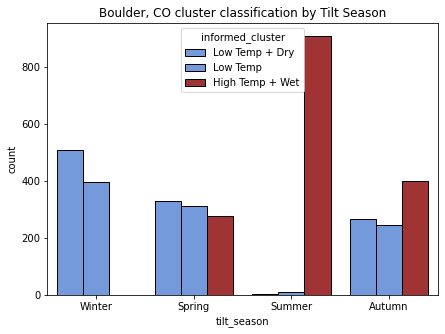

In [221]:
fig = plt.figure(figsize = (7,5))
sb.countplot(x = 'tilt_season', data = alldf.query('location == "bou"'), hue = 'informed_cluster', edgecolor = 'black', palette = palette)
plt.title("Boulder, CO cluster classification by Tilt Season")

fig.savefig("bou_class.png", bbox_inches = 'tight', dpi = 300)

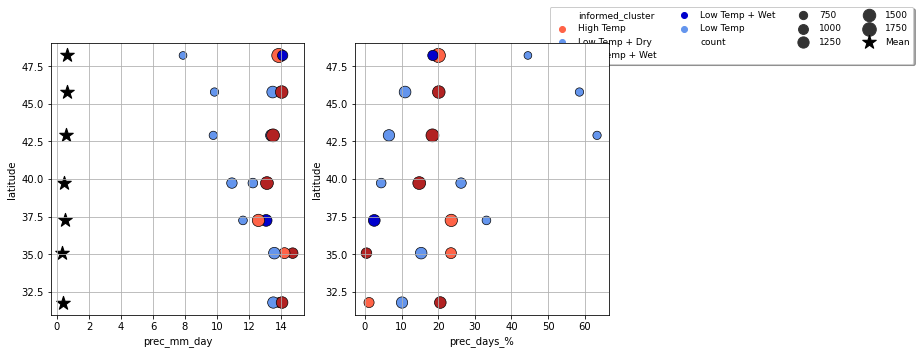

In [222]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
sb.scatterplot(x = 'prec_mm_day', y = 'latitude', data = allCentroids, hue = 'informed_cluster', palette = palette, sizes = (60,200),
               edgecolor = 'black', ax = axes[0], size = 'count')
sb.scatterplot(x = 'prec_mm_day', y = 'latitude', data = means, marker = "*", color = "black", edgecolor = "black", s = 200,
               ax = axes[0], label = "Mean")
axes[0].grid()

sb.scatterplot(x= 'prec_days_%', y = 'latitude', data = allCentroids, hue = "informed_cluster", palette = palette, sizes = (60,200),
               edgecolor = 'black', ax = axes[1], legend = False, size = 'count')
axes[1].grid()

axes[0].legend(fontsize = 9, shadow = True, bbox_to_anchor = (1.95,1.15), ncol = 4)

fig.savefig('precip.png', bbox_inches = 'tight', dpi = 300)

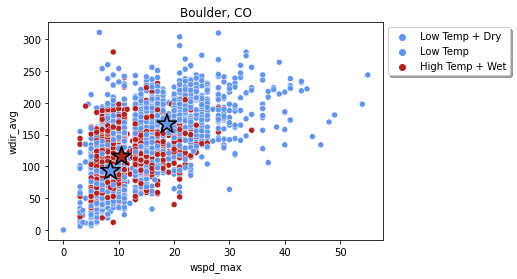

In [223]:
sb.scatterplot(x = "wspd_max", y = "wdir_avg", data = alldf.query("location == 'bou'"),
               hue = "informed_cluster", palette = palette)
sb.scatterplot(x = "wspd_max", y = "wdir_avg", data = allCentroids.query("latitude == 39.73715"),
               color = 'black', marker = "*", s = 400, hue = "informed_cluster", palette = palette, legend = False,
               edgecolor = "black")
plt.title("Boulder, CO")
plt.legend(shadow = True, bbox_to_anchor = (1,1))
plt.savefig("bouWinds.png", dpi = 300, bbox_inches = 'tight')

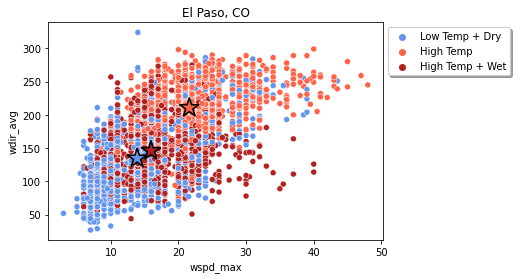

In [224]:
sb.scatterplot(x = "wspd_max", y = "wdir_avg", data = alldf.query("location == 'elp'"),
               hue = "informed_cluster", palette = palette)
sb.scatterplot(x = "wspd_max", y = "wdir_avg", data = allCentroids.query("latitude == 31.803450"),
               color = 'black', marker = "*", s = 400, hue = "informed_cluster", palette = palette, legend = False,
               edgecolor = "black")
plt.title("El Paso, CO")
plt.legend(shadow = True, bbox_to_anchor = (1,1))
plt.savefig("elpWinds.png", dpi = 300, bbox_inches = 'tight')

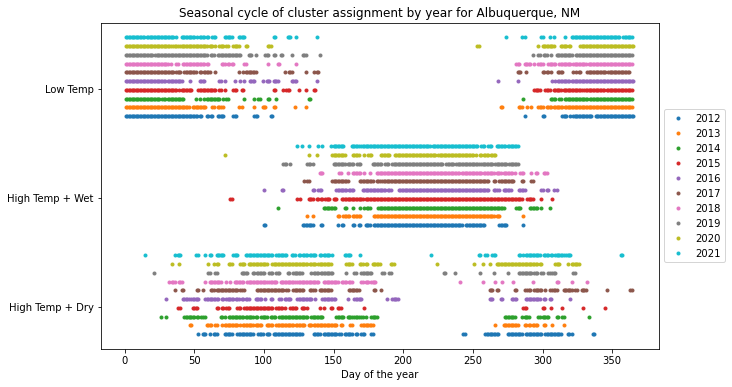

In [225]:
cluster_label_list = ['High Temp + Dry', 'High Temp + Wet', 'Low Temp']
bou['datetime'] = pd.to_datetime(alb['datetime'], format = "%Y-%m-%d")
vis.seasonal_assignment_by_year("Albuquerque, NM", cluster_label_list, 3, alb, albIdx)

plt.savefig('alb_seasonal.png', bbox_inches = 'tight', dpi = 300)

In [226]:
warmClusters = alldf.query("informed_cluster == 'High Temp' or informed_cluster == 'High Temp + Dry' or informed_cluster == 'High Temp + Wet'").reset_index(drop = True)

<AxesSubplot:xlabel='drytemp_max', ylabel='location'>

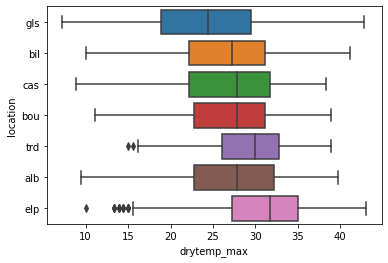

In [227]:
order = ['gls', 'bil', 'cas', 'bou','trd','alb', 'elp']
sb.boxplot(x = 'drytemp_max', y = 'location', data = warmClusters, order = order)

<AxesSubplot:xlabel='pres_tend', ylabel='location'>

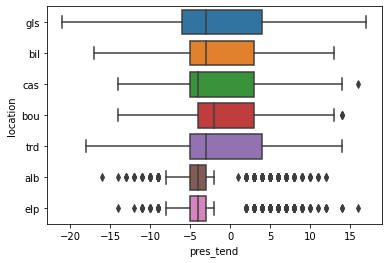

In [228]:
sb.boxplot(x = 'pres_tend', y = 'location', data = warmClusters, order = order)

<AxesSubplot:xlabel='RH_max', ylabel='location'>

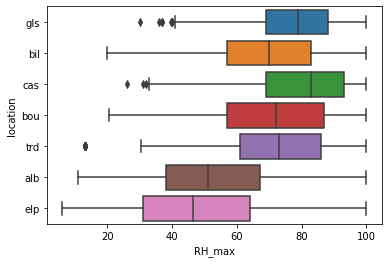

In [229]:
sb.boxplot(x = 'RH_max', y = 'location', data = warmClusters, order = order)

<AxesSubplot:xlabel='drytemp_min', ylabel='location'>

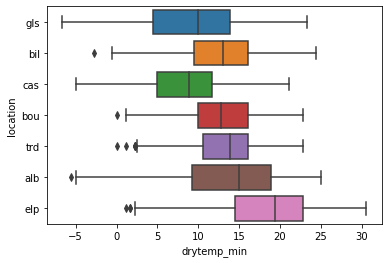

In [230]:
sb.boxplot(x = 'drytemp_min', y = 'location', data = warmClusters, order = order)

<AxesSubplot:xlabel='tilt_season', ylabel='count'>

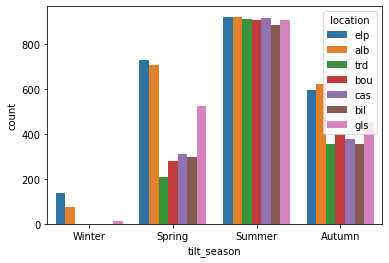

In [231]:
sb.countplot(x = 'tilt_season', hue = 'location', data = warmClusters)

KeyError: ('bil', 'Low Temp + Wet')

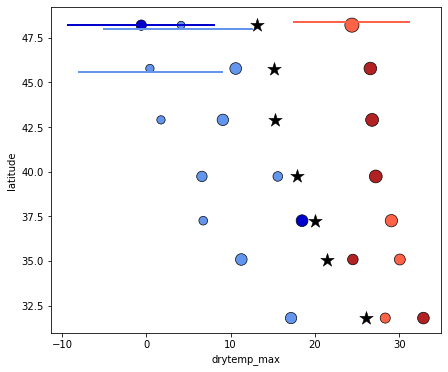

In [232]:
# added in the standard deviation of each cluster as bars around the centroids, and changes the size of the scatters to
# represent the size of the cluster
plt.figure(figsize = (7,6))
sb.scatterplot(x ='drytemp_max', y='latitude', data = allCentroids, sizes = (60,200), hue = 'informed_cluster',
               palette = palette, edgecolor = 'black', legend = False, size = 'count')
sb.scatterplot(x = 'drytemp_max', y = 'latitude', data = means, s = 200, color = 'black', marker = "*",
              edgecolor = 'black', linewidth = 0.5)

# add standard deviation lines to each point
for group in range(0,len(groups)):
    std = alldfGroups.get_group(groups[group]).describe().loc['std','drytemp_max']
    mean = alldfGroups.get_group(groups[group]).describe().loc['mean','drytemp_max']
    latitude = alldfGroups.get_group(groups[group]).describe().loc['mean','latitude']
    plt.plot([mean+std,mean-std],[latitude + offset[group%3], latitude+ offset[group%3]],
             color = palette[groups[group][1]], linewidth = 2);
plt.grid()    

In [ ]:
def variable_location_scatter(variable_name, df, means, groups, alldfGroups, save = False, figname = 'none'):
    offset = [-0.2,0,0.2]
    palette = {"High Temp + Wet":"firebrick",
           "High Temp + Dry": "tomato",
           "Low Temp + Dry":"cornflowerblue", 
           "Low Temp + Wet":"mediumblue",
           "Low Temp": 'cornflowerblue',
           "High Temp": 'tomato'}
    
    plt.figure(figsize = (7,6))
    sb.scatterplot(x = variable_name, y = 'latitude', data = df, sizes = (60,200), hue = 'informed_cluster',
                  palette = palette, edgecolor = 'black', legend = True, size = 'count')
    sb.scatterplot(x = variable_name, y = 'latitude', data = means, s = 200, color = 'black', marker = '*', 
                  edgecolor = 'black', linewidth = 0.5)
    
    for group in range(0,len(groups)):
        std = alldfGroups.get_group(groups[group]).describe().loc['std', variable_name]
        mean = alldfGroups.get_group(groups[group]).describe().loc['mean', variable_name]
        latitude = alldfGroups.get_group(groups[group]).describe().loc['mean','latitude']
        plt.plot([mean+std, mean-std],[latitude+offset[group%3], latitude+offset[group%3]],
                color = palette[groups[group][1]], linewidth = 2);
    plt.grid();
    plt.title('Centroid +- 1std for each cluster and location of the cross section: {}'.format(variable_name));
    plt.legend(shadow = True, fontsize = 9, bbox_to_anchor = (1,1));
    
    if save == True:
        plt.savefig(figname)

In [ ]:
variable_location_scatter('RH_max', allCentroids, means, groups, alldfGroups)